In [124]:
######Importing data
import pandas as pd
data = pd.read_csv(file_path)

# Print the descriptive statistics
Mydata.head()

,Country,Date,FluAcases
0,United States,1/1/2009,3766
1,United States,2/1/2009,8102
2,United States,3/1/2009,4373
3,United States,4/1/2009,4094
4,United States,5/1/2009,15120


In [125]:
# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

# Generate a basic statistical summary of the flu cases
stat_summary = data['FluAcases'].describe()

stat_summary

count       180.000000
mean      10286.194444
std       21309.480449
min          12.000000
25%         343.500000
50%        1543.500000
75%       10800.750000
max      151234.000000
Name: FluAcases, dtype: float64

C:\Users\edmun\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


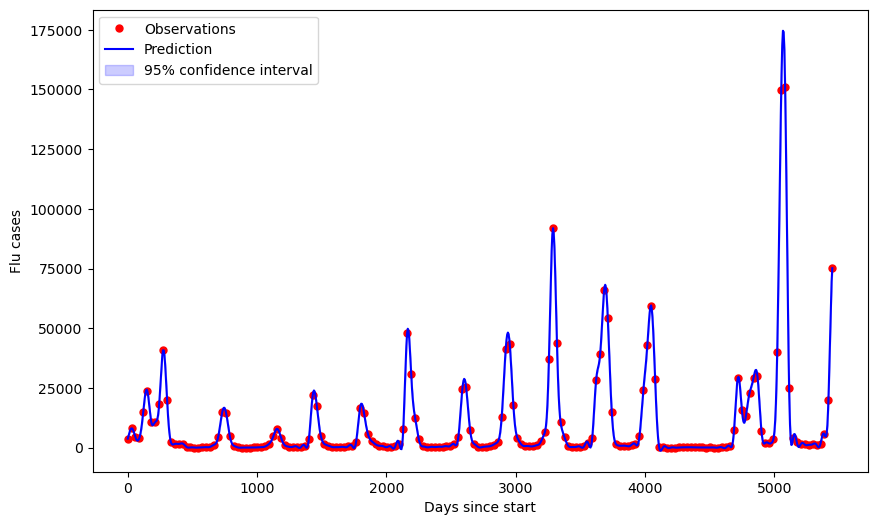

In [126]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import numpy as np

# Prepare the data
X = np.array((data['Date'] - data['Date'].min()) / np.timedelta64(1, 'D')).reshape(-1, 1)  # Days since start
Y = data['FluAcases'].values

# Define the kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, Y)

# Make predictions
X_pred = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
Y_pred, sigma = gp.predict(X_pred, return_std=True)

# Plot the function, the prediction, and the 95% confidence interval based on the GP
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(X, Y, 'r.', markersize=10, label='Observations')
plt.plot(X_pred, Y_pred, 'b-', label='Prediction')
plt.fill_between(X_pred[:, 0], Y_pred - 1.96 * sigma, Y_pred + 1.96 * sigma, alpha=0.2, color='b', label='95% confidence interval')
plt.xlabel('Days since start')
plt.ylabel('Flu cases')
# plt.title('Gaussian Process Regression on Flu Cases')
plt.legend()

plt.show()

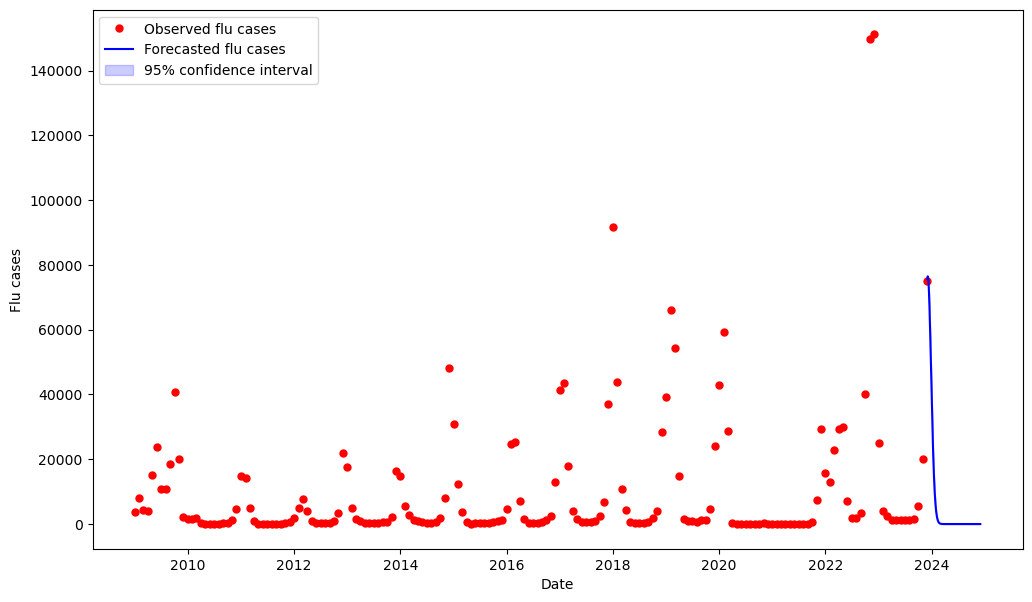

In [127]:
# Calculate the number of days to forecast into the future
latest_date = data['Date'].max()
forecast_start_date = latest_date + pd.Timedelta(days=1)
forecast_end_date = latest_date + pd.Timedelta(days=365)  # Forecast 12 months into the future

# Prepare the forecast range in days since the start of the dataset
forecast_range_days = np.array((pd.date_range(forecast_start_date, forecast_end_date) - data['Date'].min()) / np.timedelta64(1, 'D')).reshape(-1, 1)

# Forecast future flu cases
Y_forecast, sigma_forecast = gp.predict(forecast_range_days, return_std=True)

# Convert forecast days back to dates for plotting
forecast_dates = pd.date_range(forecast_start_date, forecast_end_date)

# Plot the observed data along with the forecast
plt.figure(figsize=(12, 7))
plt.plot(data['Date'], Y, 'r.', markersize=10, label='Observed flu cases')
plt.plot(forecast_dates, Y_forecast, 'b-', label='Forecasted flu cases')
plt.fill_between(forecast_dates, Y_forecast - 1.96 * sigma_forecast, Y_forecast + 1.96 * sigma_forecast, alpha=0.2, color='b', label='95% confidence interval')
plt.xlabel('Date')
plt.ylabel('Flu cases')
#plt.title('Forecast of Flu Cases Using Gaussian Process')
plt.legend()
plt.show()


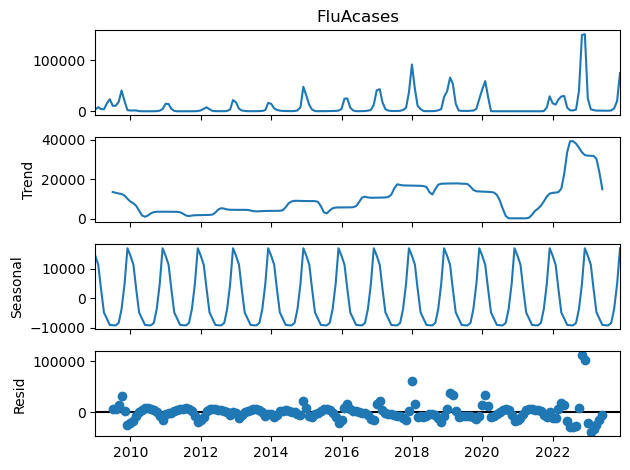

In [128]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Set the date as the index
data_indexed = data.set_index('Date')

# Perform seasonal decomposition
decomposition = seasonal_decompose(data_indexed['FluAcases'], model='additive', period=12)

# Plot the decomposed components of the time series
decomposed = decomposition.plot()
plt.show()

In [129]:
# Since the original forecast range didn't explicitly cover the full year of 2023,
# let's create a new forecast range that does cover from January 2023 to December 2023.

# Define the start and end dates for 2023
start_date_2023 = pd.Timestamp(year=2023, month=1, day=1)
end_date_2023 = pd.Timestamp(year=2023, month=12, day=31)

# Prepare the forecast range in days since the start of the dataset for 2023
forecast_range_days_2023 = np.array((pd.date_range(start_date_2023, end_date_2023) - data['Date'].min()) / np.timedelta64(1, 'D')).reshape(-1, 1)

# Forecast future flu cases for 2023
Y_forecast_2023, sigma_forecast_2023 = gp.predict(forecast_range_days_2023, return_std=True)

# Create a DataFrame for the forecasted values in 2023 for better readability
forecast_2023_full_df = pd.DataFrame({
    'Date': pd.date_range(start_date_2023, end_date_2023),
    'Forecasted Flu Cases': Y_forecast_2023
})

# Set the date as index and resample to get monthly averages for 2023
forecast_2023_full_df.set_index('Date', inplace=True)
monthly_forecast_2023_full = forecast_2023_full_df.resample('M').mean()

monthly_forecast_2023_full

,Forecasted Flu Cases
Date,
2023-01-31,6335.737680
2023-02-28,4746.775600
2023-03-31,849.732557
2023-04-30,1757.717197
2023-05-31,1089.035766
2023-06-30,1210.848245
2023-07-31,1588.898696
2023-08-31,571.391611
2023-09-30,4582.053546


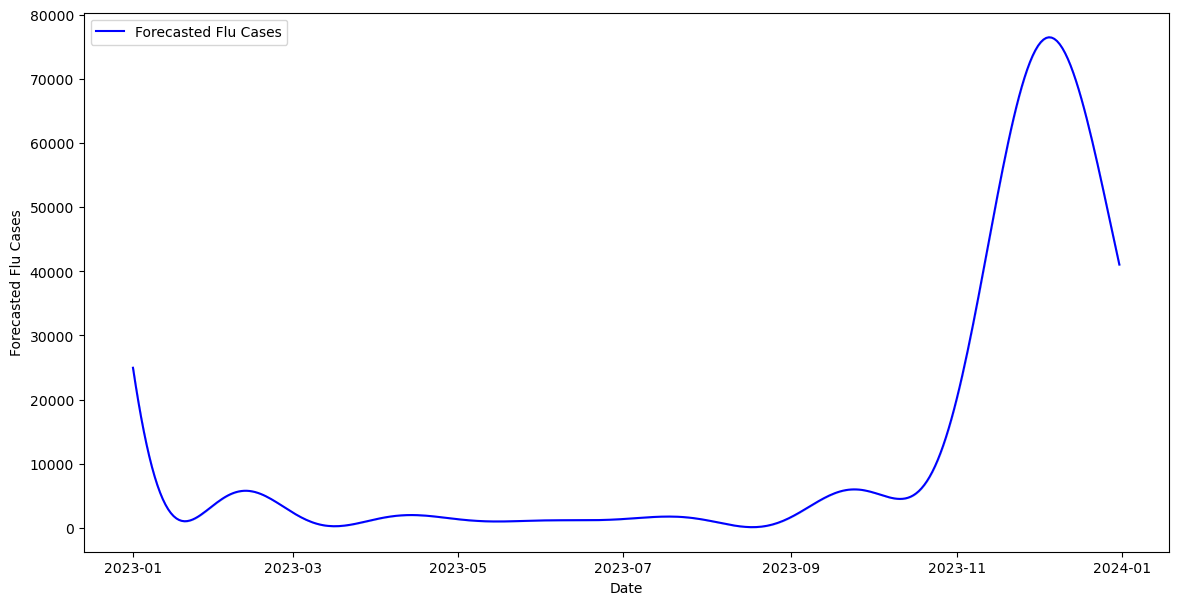

In [130]:
# Prepare the data for plotting
dates_2023 = pd.date_range(start_date_2023, end_date_2023)
mean_forecast_2023 = Y_forecast_2023
uncertainty_2023 = sigma_forecast_2023

# Plot the forecasted flu cases with uncertainty
plt.figure(figsize=(14, 7))
plt.fill_between(dates_2023, mean_forecast_2023 - 1.96 * uncertainty_2023, mean_forecast_2023 + 1.96 * uncertainty_2023, color='lightblue', alpha=0.5)
plt.plot(dates_2023, mean_forecast_2023, 'b-', label='Forecasted Flu Cases')
plt.xlabel('Date')
plt.ylabel('Forecasted Flu Cases')
#plt.title('Forecasted Flu Cases with Uncertainty Quantification for 2023')
plt.legend()
plt.show()


In [131]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train the GP model on the training set
gp.fit(X_train, Y_train)

# Make predictions on the test set
Y_pred = gp.predict(X_test)

C:\Users\edmun\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


C:\Users\edmun\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\edmun\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\edmun\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\edmun\anaconda3\Lib\site-packages\sklearn\gaussian_process\kerne

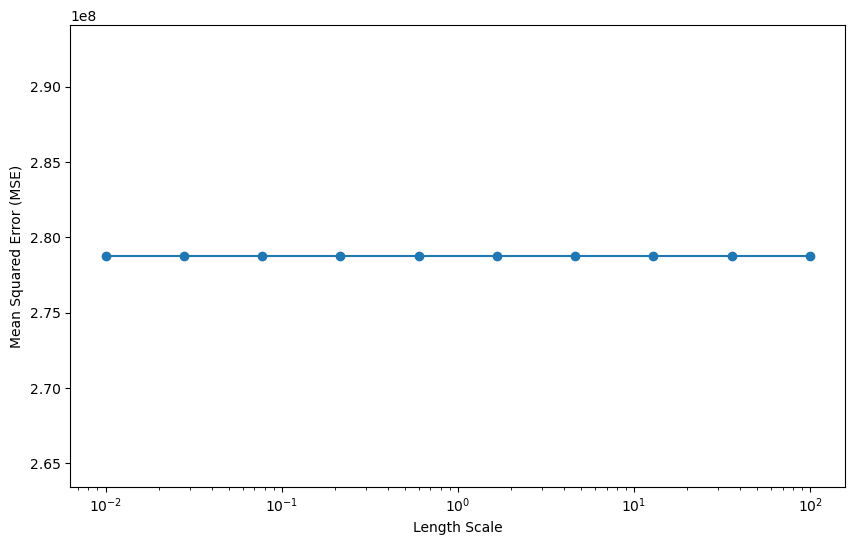

In [132]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error

# Function to train GP model with varying length scales and return MSE
def evaluate_gp_length_scale(length_scale):
    kernel = C(1.0) * RBF(length_scale)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X_train, Y_train)
    Y_pred = gp.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    return mse

# Define a range of length scales to test
length_scales = np.logspace(-2, 2, 10)

# Evaluate the model performance for each length scale
mse_values = [evaluate_gp_length_scale(ls) for ls in length_scales]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(length_scales, mse_values, marker='o')
plt.xscale('log')
plt.xlabel('Length Scale')
plt.ylabel('Mean Squared Error (MSE)')
#plt.title('Hyperparameter Sensitivity: Length Scale of RBF Kernel')
plt.show()

C:\Users\edmun\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\edmun\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\edmun\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\edmun\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py

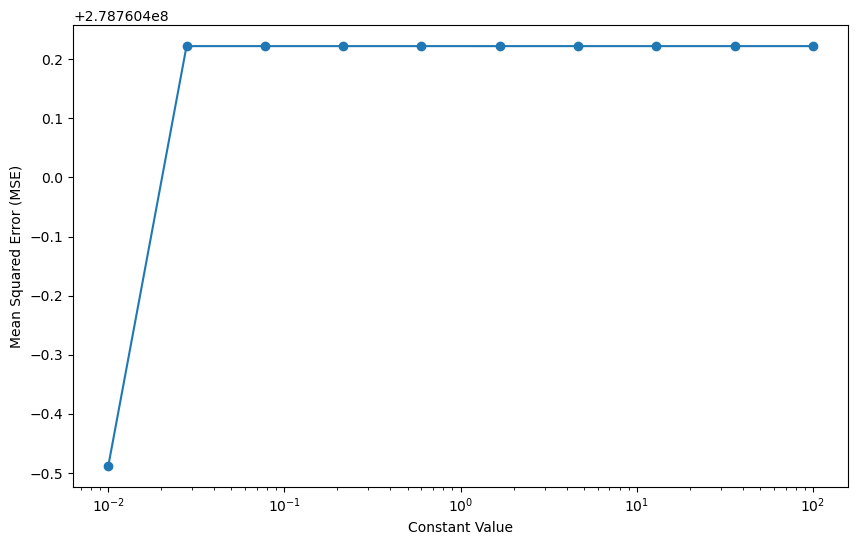

In [133]:
# Function to train GP model with varying constant values and return MSE
def evaluate_gp_constant_value(constant_value):
    kernel = C(constant_value) * RBF(10)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X_train, Y_train)
    Y_pred = gp.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    return mse

# Define a range of constant values to test
constant_values = np.logspace(-2, 2, 10)

# Evaluate the model performance for each constant value
mse_values_constant = [evaluate_gp_constant_value(cv) for cv in constant_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(constant_values, mse_values_constant, marker='o')
plt.xscale('log')
plt.xlabel('Constant Value')
plt.ylabel('Mean Squared Error (MSE)')
#plt.title('Hyperparameter Sensitivity: Constant Value of Constant Kernel')
plt.show()

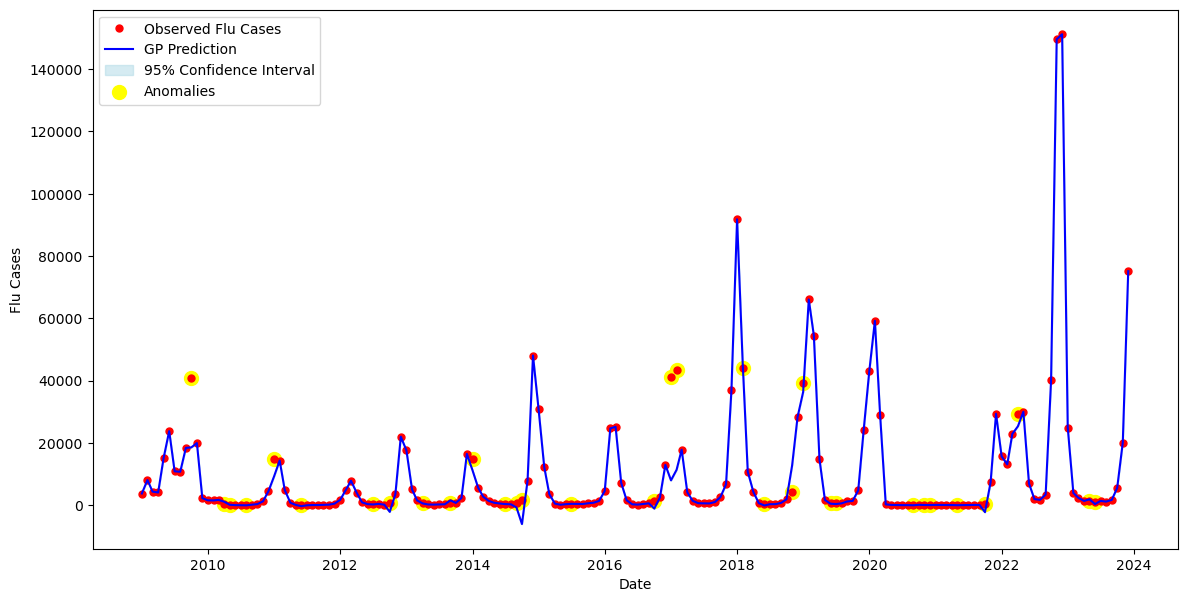

(32,
 array([  9,  15,  16,  19,  24,  29,  42,  45,  51,  56,  60,  66,  68,
         69,  78,  93,  96,  97, 109, 113, 118, 120, 125, 126, 140, 142,
        143, 148, 153, 159, 172, 173], dtype=int64))

In [134]:
# Predict on the original dataset's date range to get confidence intervals
Y_pred_original, sigma_original = gp.predict(X, return_std=True)

# Calculate the 95% confidence intervals
upper_bound = Y_pred_original + 1.96 * sigma_original
lower_bound = Y_pred_original - 1.96 * sigma_original

# Identify data points where the actual flu cases fall outside the confidence intervals
anomalies = np.where((Y > upper_bound) | (Y < lower_bound))[0]

# Plot the results, highlighting anomalies
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], Y, 'r.', markersize=10, label='Observed Flu Cases')
plt.plot(data['Date'], Y_pred_original, 'b-', label='GP Prediction')
plt.fill_between(data['Date'], lower_bound, upper_bound, color='lightblue', alpha=0.5, label='95% Confidence Interval')
plt.scatter(data.iloc[anomalies]['Date'], Y[anomalies], s=100, c='yellow', label='Anomalies')
plt.xlabel('Date')
plt.ylabel('Flu Cases')
#plt.title('Flu Cases with Anomalies Highlighted')
plt.legend()
plt.show()

len(anomalies), anomalies


In [135]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [136]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# Create lagged features for the flu cases
data_indexed['Lag_1'] = data_indexed['FluAcases'].shift(1)
data_indexed['Lag_2'] = data_indexed['FluAcases'].shift(2)
data_indexed['Lag_3'] = data_indexed['FluAcases'].shift(3)

# Drop rows with NaN values resulting from lagging
data_indexed.dropna(inplace=True)

# Define the features and target variable
X_lagged = data_indexed[['Lag_1', 'Lag_2', 'Lag_3']]
Y_lagged = data_indexed['FluAcases']

# Split the data into training and testing sets
X_train_lagged, X_test_lagged, Y_train_lagged, Y_test_lagged = train_test_split(X_lagged, Y_lagged, test_size=0.2, shuffle=False)

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100)
xgb_model.fit(X_train_lagged, Y_train_lagged)

# Predict on the test set
Y_pred_lagged = xgb_model.predict(X_test_lagged)

# Evaluate the model
mae_lagged = mean_absolute_error(Y_test_lagged, Y_pred_lagged)
rmse_lagged = np.sqrt(mean_squared_error(Y_test_lagged, Y_pred_lagged))

mae_lagged, rmse_lagged

(12429.371742354499, 26835.319406614028)

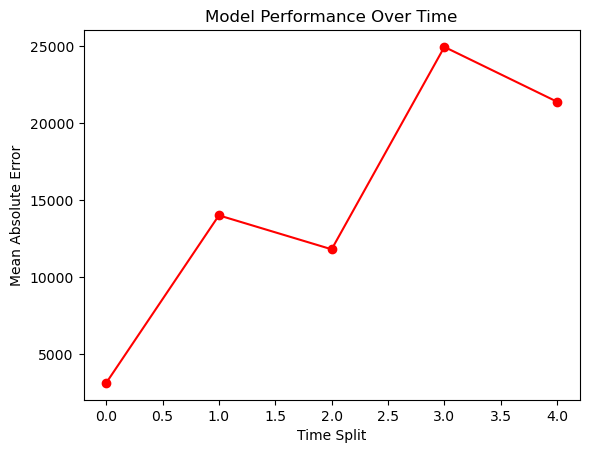

In [140]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt

# Assuming X, Y are your features and target arrays, respectively

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

mae_scores = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    model = XGBRegressor(n_estimators=100, objective='reg:squarederror')
    model.fit(X_train, Y_train)
    
    predictions = model.predict(X_test)
    mae = mean_absolute_error(Y_test, predictions)
    mae_scores.append(mae)

# Plotting MAE over time
plt.plot(mae_scores, marker='o', linestyle='-', color='r')
plt.xlabel('Time Split')
plt.ylabel('Mean Absolute Error')
plt.title('Model Performance Over Time')
plt.show()


# Wavelength Transform Analysis

C:\Users\edmun\anaconda3\Lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


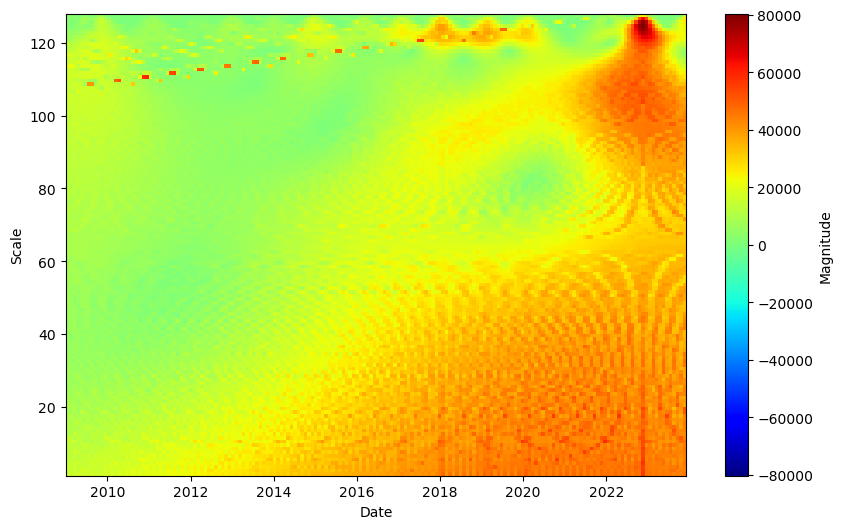

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Assuming 'date' is your datetime column and 'cases' is the Flu cases
# Convert date column to datetime type if it's not already
data['Date'] = pd.to_datetime(data['Date'])
# Ensure your cases column is in float
data['FluAcases'] = data['FluAcases'].astype(float)

# Perform Continuous Wavelet Transform
# Selecting an appropriate wavelet, 'cmor' is good for time series data
wavelet = 'cmor'
scales = np.arange(1, 128)  # Range of scales to perform the transform

# Assuming 'cases' column is what we're analyzing
signal = data['FluAcases'].values
coefficients, frequencies = pywt.cwt(signal, scales, wavelet, 1)

# Plot the Wavelet Transform result
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coefficients), extent=[data['Date'].min(), data['Date'].max(), 1, 128], cmap='jet', aspect='auto', vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())
plt.colorbar(label='Magnitude')
plt.ylabel('Scale')
plt.xlabel('Date')
#plt.title('Continuous Wavelet Transform (CWT) of Flu Cases')
plt.show()


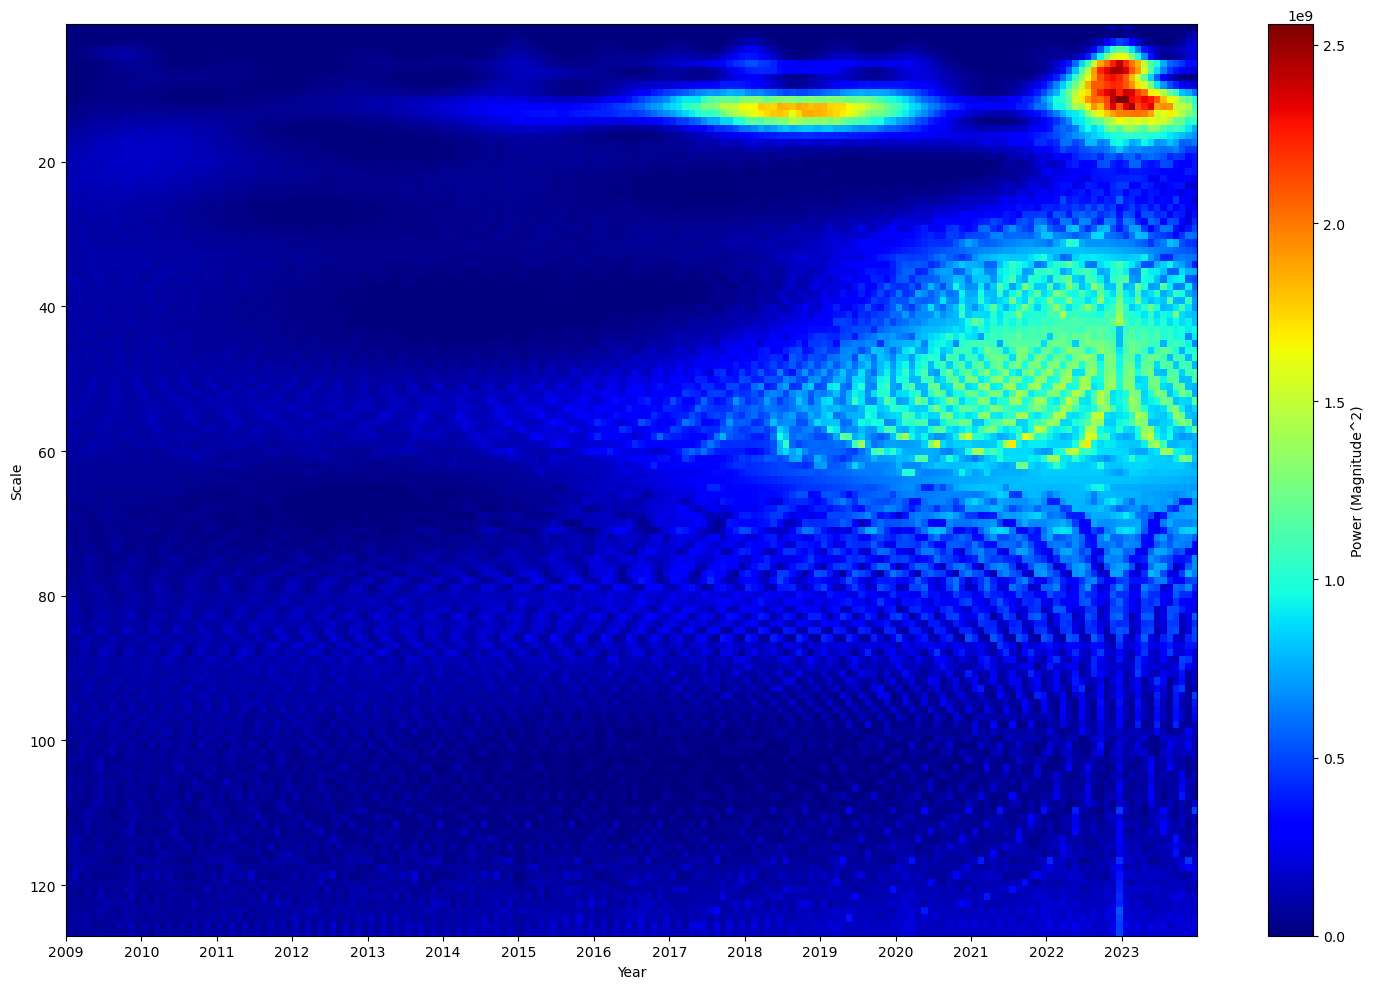

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt

# Load the dataset
data = pd.read_csv(r"C:\Users\edmun\Desktop\UTRGV Thesis\Manuscript 1\Data and Codes\USA.csv", parse_dates=['Date'], index_col='Date')


# Assuming the column with Flu cases is named 'FluAcases'
signal = data['FluAcases'].values

# Define wavelet parameters
wavelet = 'cmor1.5-1.0'
scales = np.arange(1, 128)

# Perform Continuous Wavelet Transform (CWT)
coefficients, freqs = pywt.cwt(signal, scales, wavelet, 1)

# Calculate the power spectrum
power_spectrum = (np.abs(coefficients)) ** 2

# Create a list of years from the dataset
years = np.arange(2009, 2024)

# Find the indexes for the first occurrence of each year in the dataset
year_indexes = [data.index.get_loc(data[data.index.year == year].index[0]) for year in years]

# Plot the Wavelet Power Spectrum
plt.figure(figsize=(15, 10))
plt.imshow(power_spectrum, extent=[0, len(signal), scales[-1], scales[0]], cmap='jet', aspect='auto')
plt.colorbar(label='Power (Magnitude^2)')
plt.ylabel('Scale')
plt.xlabel('Year')

# Set the x-ticks to match the positions of the years and label them
plt.xticks(year_indexes, years)
#plt.title('Wavelet Power Spectrum of Flu Cases')
plt.tight_layout()  # Ensure everything fits without overlapping
plt.show()
